In [1]:
# Fig2 related figures, for Nature methods paper review

In [1]:
library(dplyr)
library(tidyverse)
library(ggsci)
library(ggrepel)
library(circlize)
library(scales)
library(ComplexHeatmap)
library(ggplot2)
source('./common_amplicon_statistics.r')


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ ggplot2   3.5.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
circlize version 0.4.15
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visuali

In [2]:
umi_table = read.csv('../data/sc293T/scHEK293T_umi_table.csv')

# check intBC distribution per cell

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   3.00   18.00   21.00   19.99   23.00   68.00 


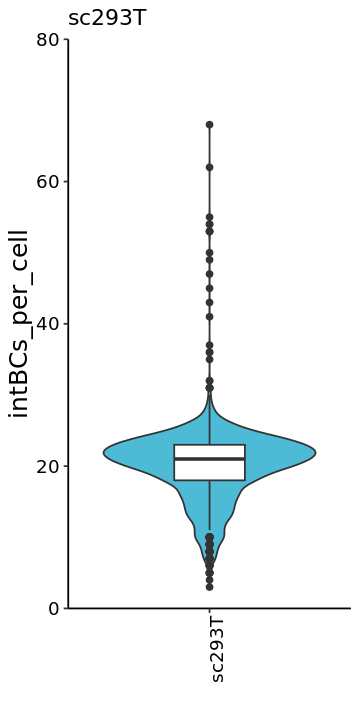

In [3]:
options(repr.plot.width=3, repr.plot.height=6)

colors = pal_npg(palette = c("nrc"), alpha = 1)(6)
intBC_per_cell_violin(umi_table, colors[2], 80, "sc293T")
    #geom_hline(yintercept=24, linetype="dashed",colour="red")
ggsave("../results/Fig2_sc293T_intBC_per_cell.pdf", width=4, height=8)

# check PCA distribution of indels among 24 intBCs

In [4]:
top20bc = umi_table %>% group_by(intBC) %>% reframe(nUMI = length(UMI)) %>% arrange(desc(nUMI)) %>% head(24)
order_intBC_conversion = setNames(paste0('intBC', 1:24), top20bc$intBC)

In [5]:
umi_table = umi_table %>% select(X, intBC, CIGAR, r1, r2, r3, r4)
selected_umi_table = umi_table %>% filter(intBC %in% top20bc$intBC)

intBC_cigar = selected_umi_table %>% group_by(intBC, CIGAR) %>% reframe(nUMI = length(X)) 

intBC_cigar$intBCs = order_intBC_conversion[intBC_cigar$intBC]
intBC_cigar = intBC_cigar[, 2:4]

In [6]:
intBC_cigar_longer = intBC_cigar %>% pivot_wider(id_cols = intBCs, names_from = CIGAR, values_from = nUMI) 
intBC_cigar_longer = as.data.frame(intBC_cigar_longer)
rownames(intBC_cigar_longer) = intBC_cigar_longer$intBCs
intBC_cigar_longer = intBC_cigar_longer[, 2:ncol(intBC_cigar_longer)] 
intBC_cigar_longer[is.na(intBC_cigar_longer)] <- 0

In [7]:
# normalized by readCounts
df_scaled <- apply(intBC_cigar_longer, 1, function(row) {
  row_size <- sum(row)
  row <- row / row_size * 10000
  return(row)
})

# Convert the matrix back to a data frame
df_scaled <- t(as.data.frame(df_scaled))

In [8]:
# Assume 'df' is your data frame
pca_result <- prcomp(df_scaled, scale. = TRUE)

# Load the necessary libraries
library(ggplot2)

# Assume 'pca_result' is the result of your PCA
pca_data <- as.data.frame(pca_result$x)

# Add a column for your factor variable if necessary
# pca_data$factor_variable <- df$factor_variable

pca_data = pca_data[, 1:2]
# pca_data$intBCs = paste0('intBC', 1:24)

In [9]:
pca_data$intBCs = rownames(pca_data)
pca_data$order_num = as.numeric(sub('intBC', '', pca_data$intBCs))
pca_data = pca_data %>% arrange(order_num)
pca_data$intBCs = factor(pca_data$intBCs, levels = paste0('intBC', 1:24))
head(pca_data)

,PC1,PC2,intBCs,order_num
,<dbl>,<dbl>,<fct>,<dbl>
intBC1,135.069929,-1.564302,intBC1,1
intBC2,-6.940704,7.032249,intBC2,2
intBC3,-7.883449,8.627945,intBC3,3
intBC4,-3.875696,1.938325,intBC4,4
intBC5,-8.189167,-102.080857,intBC5,5
intBC6,-5.755663,4.442298,intBC6,6


Warning message:
“ggrepel: 22 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 21 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


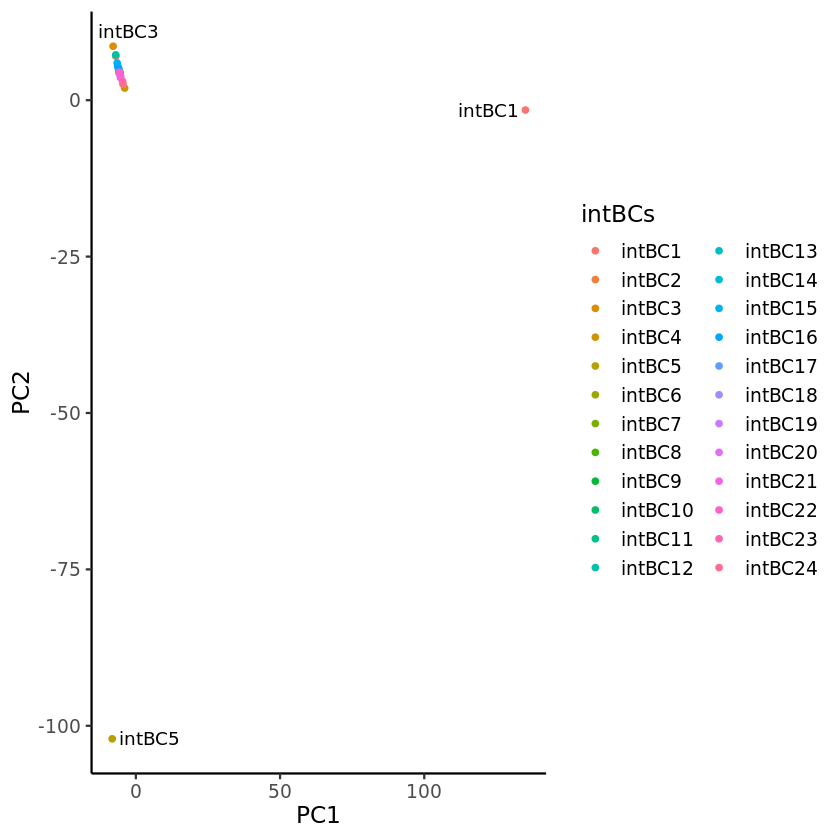

In [10]:
options(repr.plot.width=7, repr.plot.height=7)
ggplot(pca_data, aes(x = PC1, y = PC2)) +
  geom_point(aes(color = intBCs)) +  # Remove 'color' argument if no factor variable
  xlab("PC1") +
  ylab("PC2") +
  geom_text_repel(aes(label = intBCs))+
  theme_classic(base_size=14)
ggsave('../results/Fig2_T293clone1_mutation_pattern_distribution.pdf', width=7, height=7)

# simulation on sc293T

In [11]:
library(dplyr)
# library(reticulate) #for running python scripts
# library(ggtree)
# library(treeio)
# library(tidytree)
library(tidyverse)
library(ggsignif)
library(ggsci)
library(scales)
library(ggplot2)

In [12]:
allele_table = read.csv('../data/sc293T/scHEK293T_allele_table_greedy.csv')

In [ ]:
# This script would take several hours to run, which is not practical in code ocean, only provided final calculated results for plotting
# call_mean_depth = function(allele_table,repetition=100) {
#     alltarget_mean = vector()
#     cpf1_target_mean = vector()
#     cas9_target_mean = vector()
#     cell_number = n_distinct(allele_table$cellBC)
#     for (i in 1:repetition) {
#         simulation_target_table = simulation_table(allele_table)
#         alltarget_table = simulation_target_table[[1]]
#         cpf1_target_table = simulation_target_table[[2]]
#         cas9_target_table = simulation_target_table[[3]]
#         write.csv(alltarget_table, "~/dualproject/sample293Tv2/T293_all_target_simulation_allele_table.csv")
#         write.csv(cpf1_target_table, "~/dualproject/sample293Tv2/T293_cpf1_target_simulation_allele_table.csv")
#         write.csv(cas9_target_table, "~/dualproject/sample293Tv2/T293_cas9_target_simulation_allele_table.csv")

#         #test the running of python script to obtain the tree using cassiopeia packages
#         #BE CAREFUL, source_python function will absorb the variables and functions from python, making R variable  strange
#         #source_python("./T293_simulation_all_target.py")
#         py_run_file("~/dualproject/sample293Tv2/T293_simulation_all_target.py")
#         tree<-read.newick("~/dualproject/sample293Tv2/newick_trees/tree_all_target.newick",node.label = "label")
#         #calculate the mean tree depth, the tree is reconstructed using Cas9 targets only
#         tree_depth = castor::get_all_distances_to_root(tree)
#         #summary(tree_depth[1:cell_number])
#         #mean_all_tree_depth = mean(tree_depth[1:cell_number]) #mean value is integer and avoid outliers
#         #mean seem to be the major cause for the apperance of biomodal distribution, change to mean
#         mean_all_tree_depth = mean(tree_depth[1:cell_number])
#         alltarget_mean = append(alltarget_mean, mean_all_tree_depth)

#         #test the running of python script to obtain the tree using cassiopeia packages
#         #source_python("./T293_simulation_cpf1_target.py")
#         py_run_file("~/dualproject/sample293Tv2/T293_simulation_cpf1_target.py")
#         #tree<-read.newick("~/dualproject/sample293Tv2/newick_trees/tree_cas9target.newick",node.label = "label") #one error here
#         tree<-read.newick("~/dualproject/sample293Tv2/newick_trees/tree_cpf1target.newick",node.label = "label")
#         #calculate the mean tree depth, the tree is reconstructed using Cas9 targets only
#         tree_depth = castor::get_all_distances_to_root(tree)
#         #summary(tree_depth[1:cell_number])
#         mean_cpf1_tree_depth = mean(tree_depth[1:cell_number]) #mean value is integer and avoid outliers, but may induce multi-modal distribution
#         #mean_cpf1_tree_depth = mean(tree_depth[1:cell_number]) #change to using "mean" instead
#         cpf1_target_mean = append(cpf1_target_mean, mean_cpf1_tree_depth)

#         #test the running of python script to obtain the tree using cassiopeia packages
#         #source_python("./T293_simulation_cas9_target.py")
#         py_run_file("~/dualproject/sample293Tv2/T293_simulation_cas9_target.py")
#         tree<-read.newick("~/dualproject/sample293Tv2/newick_trees/tree_cas9target.newick",node.label = "label")
#         #calculate the mean tree depth, the tree is reconstructed using Cas9 targets only
#         tree_depth = castor::get_all_distances_to_root(tree)
#         #summary(tree_depth[1:cell_number])
#         mean_cas9_tree_depth = mean(tree_depth[1:cell_number]) #mean value is integer and avoid outliers 
#         cas9_target_mean = append(cas9_target_mean, mean_cas9_tree_depth)
#         }
#     simulation_mean = data.frame(alltarget_mean,  cpf1_target_mean, cas9_target_mean)
#     return(simulation_mean)
           
# }

In [ ]:
# options(dplyr.summarise.inform = FALSE)
# mean_tree_depth = call_mean_depth(allele_table, repetition=100)
# tree_depth = mean_tree_depth %>% pivot_longer(cols=1:3, names_to = "target", values_to = "tree_depth_mean") 
# tree_depth$target = factor(tree_depth$target, levels=c("alltarget_mean","cpf1_target_mean","cas9_target_mean"))
# write.csv(tree_depth, "~/dualproject/figures/fig2sc293T/dual_target_tree_depth_comparison_mean.csv")

In [21]:
# provided intermediate results instead
tree_depth = read.csv("../data/sc293T/dual_target_tree_depth_comparison_mean.csv")

In [22]:
tree_depth$target = factor(tree_depth$target, levels = c('alltarget_mean', 'cpf1_target_mean', 'cas9_target_mean'))

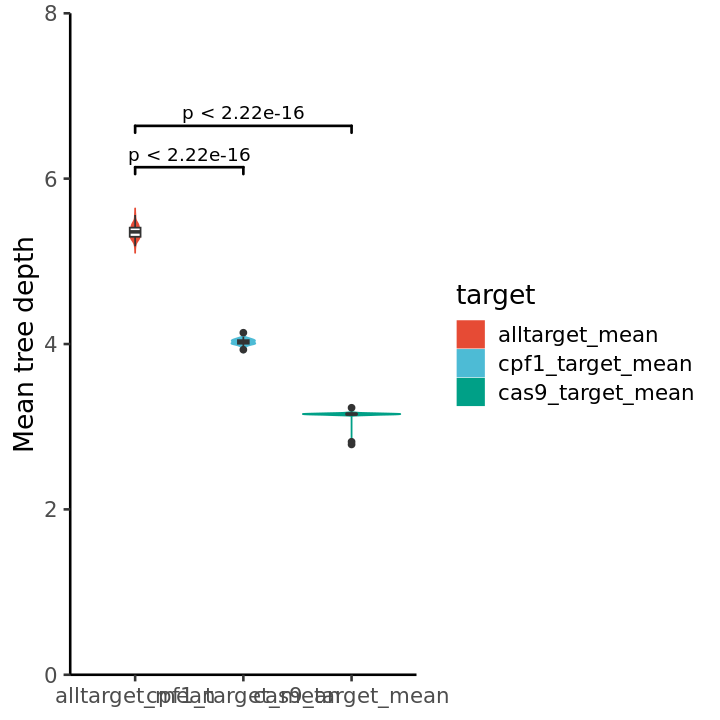

In [23]:
#should use violin_plot instead
options(repr.plot.width=6, repr.plot.height=6)
compaired = list(c("alltarget_mean","cpf1_target_mean"), c("alltarget_mean", "cas9_target_mean"))
ggplot(tree_depth, aes(x=target,y=tree_depth_mean))+
    #geom_bar(stat="summary",fun=mean, alpha=0.7)+ #柱状图
   #geom_hpline(stat = "summary")+
    geom_violin(aes(color=target,fill=target), trim=FALSE)+geom_boxplot(width=0.1)+
    theme_classic(base_size = 16)+scale_color_npg()+scale_fill_npg()+
    geom_signif(comparisons = compaired, size=0.75, y_position = c(6, 6.5), test = 't.test')+
    labs(x=NULL,y='Mean tree depth')+scale_y_continuous(expand=c(0,0),limits=c(0,8))
    #geom_jitter(width = 0.1,size=1.5,color='black',pch=21,fill='lightgrey')
ggsave("../results/Fig2_dual_target_tree_depth_comparison_mean.pdf", width=6, height=6)

# simulation of intBC number

In [ ]:
# simulated datasets generated by a python script: simulation_optimized_cpf1_cas9targets.py
# iput for this python script is: 
# allele_table = read.csv("/data1/home/gdpeng/chengchen/dualproject/targetProcessData/293Tv2_preprocess_pipeline/allele_table_greedy.csv")
# output: T293intBC_simulation_tree_depth_separate_targets.csv
# This script would take hours to run, which is not practical in codeOcean, provided intermediate results instead

In [24]:
tree_depth = read.csv('../data/sc293T/T293intBC_simulation_tree_depth_separate_targets.csv', row.names=1)
head(tree_depth)

,intBCnum,depth_all,cpf1depth,cas9depth
,<int>,<dbl>,<dbl>,<dbl>
0,1,1.854609,1.848000,1.992000
1,1,1.859826,1.851826,1.992696
2,1,1.853913,1.845217,1.994783
3,1,2.772522,1.838957,2.996174
4,1,1.861913,1.850435,1.997565
5,1,1.853217,1.844870,1.992000


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


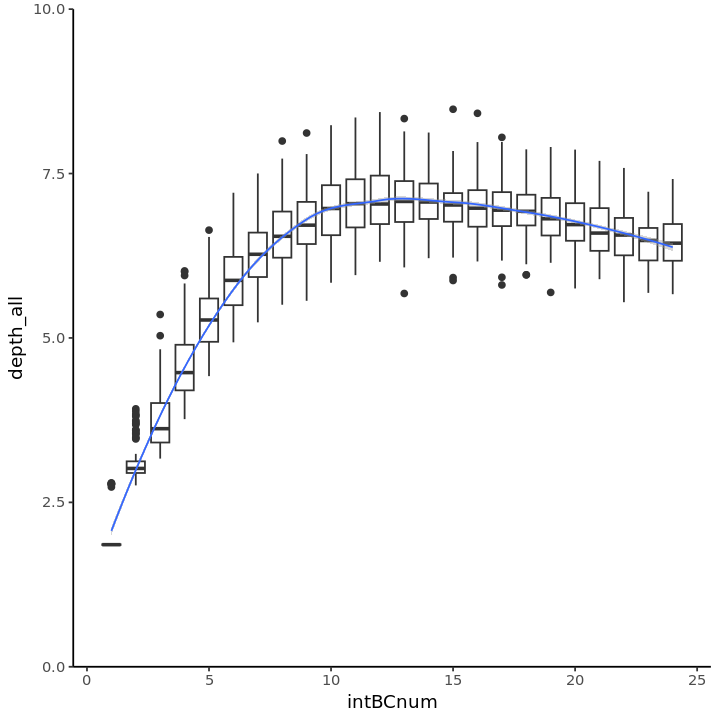

In [25]:
options(repr.plot.width=6, repr.plot.height=6)
ggplot(tree_depth, aes(x=intBCnum, y=depth_all))+geom_boxplot(aes(group=intBCnum))+geom_smooth(method = "loess", linewidth=0.5)+
    scale_y_continuous(limits=c(0,10), expand=c(0,0))+theme_classic()
ggsave('../results/Fig2_T293clone1_intBC_treedepth_sim_alltargets.pdf', width=6, height=6)


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


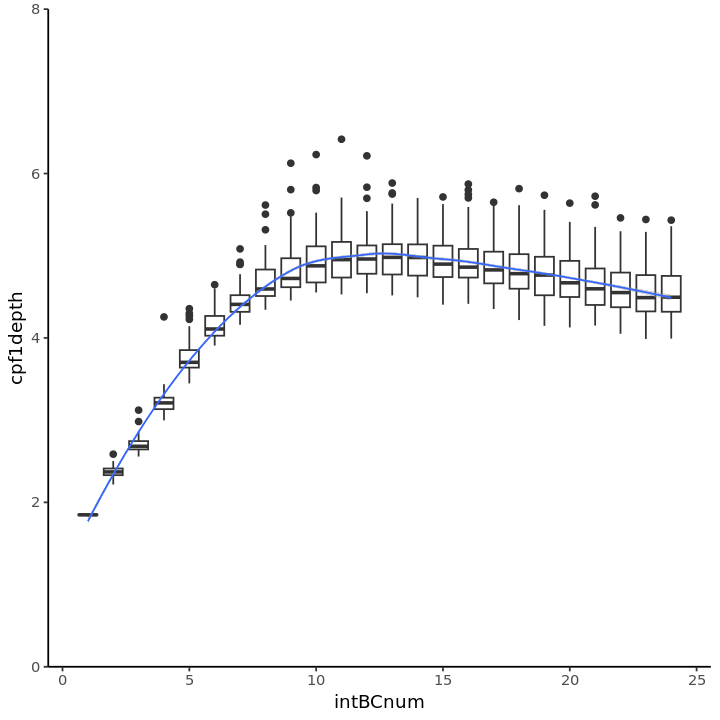

In [26]:
options(repr.plot.width=6, repr.plot.height=6)
ggplot(tree_depth, aes(x=intBCnum, y=cpf1depth))+geom_boxplot(aes(group=intBCnum))+geom_smooth(method = "loess", linewidth=0.5)+
    scale_y_continuous(limits=c(0,8), expand=c(0,0))+theme_classic()
ggsave('../results/Fig2_T293clone1_intBC_treedepth_sim_cpf1targets.pdf', width=6, height=6)


`geom_smooth()` using formula = 'y ~ x'


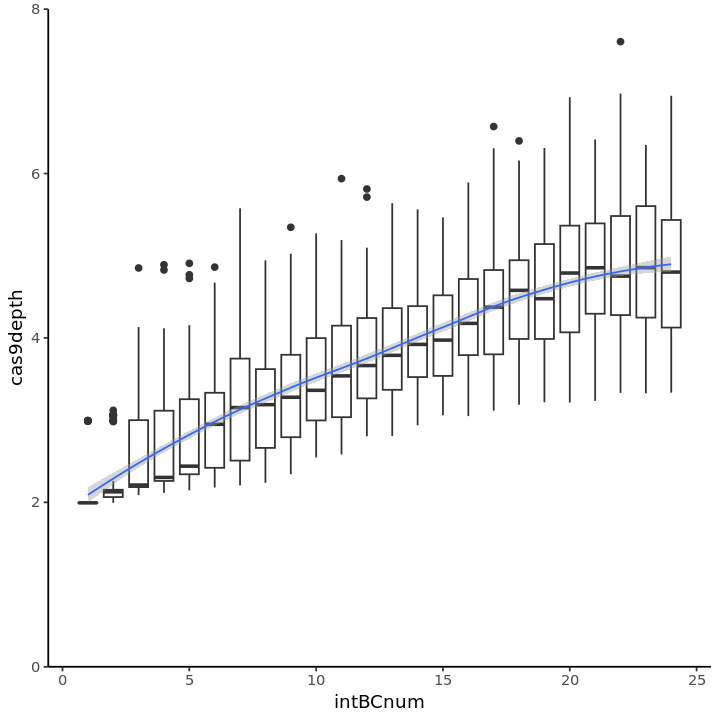

In [27]:
options(repr.plot.width=6, repr.plot.height=6)
ggplot(tree_depth, aes(x=intBCnum, y=cas9depth))+geom_boxplot(aes(group=intBCnum))+geom_smooth(method = "loess", linewidth=0.5)+
    scale_y_continuous(limits=c(0,8), expand=c(0,0))+theme_classic()
# ggsave('../results/Fig2_T293clone1_intBC_treedepth_sim_cas9targets.pdf', width=6, height=6)

In [ ]:
# some scripts for plot the scHEK293T phylogenetic tree, not actually run, final newick file is provided

In [39]:
# the python script for genereating the scHEK293T clone1 phylogenetic tree, please install python cassiopeia package first.
# allele_table = pd.read_csv(output_directory+"/allele_table_greedy.csv")
# indel_priors = pd.read_csv("/data1/home/gdpeng/chengchen/dualproject/sample293Tv2/sc293T_indel_priors.csv", index_col=0)
# CLONE = 1
# clone_allele_table = allele_table[allele_table['lineageGrp'] == CLONE]
# character_matrix, priors, state_2_indel = cas.pp.convert_alleletable_to_character_matrix(clone_allele_table,
#                                                                                          allele_rep_thresh = 0.9,
#                                                                                          mutation_priors = indel_priors)
# cas_tree = cas.data.CassiopeiaTree(character_matrix=character_matrix, priors=priors)
# # create a basic vanilla greedy solver
# vanilla_greedy = cas.solver.VanillaGreedySolver()

# # reconstruct the tree
# vanilla_greedy.solve(cas_tree, collapse_mutationless_edges=True)
# fig = cas.pl.plot_matplotlib(cas_tree, add_root=True)[1]
# fig.figure.savefig('/data1/home/gdpeng/chengchen/dualproject/figures/sc293T_filtered_greedy.pdf',format='pdf')
# with open('/data1/home/gdpeng/chengchen/dualproject/sample293Tv2/newick_trees/sc293T_greedy_original.newick', 'w') as treefile:
#     treefile.write(cas_tree.get_newick())

In [38]:
# origingal tree generated from allele_table_greedy.csv using cassiopeia-greedy tree reconstruction method
# tree<-read.newick("/data1/home/gdpeng/chengchen/dualproject/sample293Tv2/newick_trees/sc293T_greedy_original.newick", node.label = "label")
# # tree<-read.newick("/data1/home/gdpeng/chengchen/dualproject/sample293T/sample293Tclone2.nwk", node.label = "label")
# options(repr.plot.width=8, repr.plot.height=8)
# ggtree(tree, layout='circular') ##ggtree() function cannot plot rooted tree as plot_matplotlib function in cassiopeia